In [1]:
import numpy as np
import os, os.path
import csv 
from sklearn.utils import shuffle
from sklearn.model_selection import  StratifiedKFold
from collections import namedtuple
from sklearn import tree
import math
import matplotlib.pyplot as plt
import numpy.matlib
from sklearn.model_selection import train_test_split

In [2]:
def CalculateEpsilon (D , PredictionSet , Labels ) :
    PredictionSet = np.array(PredictionSet)
    Labels = np.array(Labels)
    ErrorIndeces = np.where(PredictionSet !=Labels)[0]
    EpsilonKT = sum(np.take(D, ErrorIndeces))
    return EpsilonKT / (1 - EpsilonKT)

In [3]:
def ClassifyEnsemble (NetBeta, Netmclass, NetClassifiers , Data, Label, Limit):
    Weights = []
    for Value in (np.array(NetBeta)) : 
        #print(Value)
        if Value == 0 :
            np.inf
            Weights.append(np.inf)
        else :
            Weights.append(math.log10(1/Value))
    Weights = np.array(Weights)
    P = np.zeros((len(Label),Netmclass))
    for k in range(0,Limit) :
        PredictionK = NetClassifiers[k].predict(Data)
        PredictionK = np.array(PredictionK)
        #print(PredictionK.shape ,P.shape , Weights.shape )
        
        for m in range(0, len(PredictionK)) : 
            #print("[m]" ,m )
            #print("PredictionK[m]" ,PredictionK[m] )
            #print("P[m,PredictionK[m]] " ,P[m][int(PredictionK[m])]  )
            P[m][int(PredictionK[m])]  = P[m][int(PredictionK[m])] + Weights[k]
    return np.argmax(P,axis=1) , np.matlib.repmat(np.sum(P,axis = 1)[..., None],1,2)



In [4]:
def Learn(Net , DataTrain , LabelTrain, DataTest, LabelTest):
    Tk = Net.iterations #number of classifiers to generate
    K = len(DataTrain) #number of data sets 
    ###### porer code ta kaj na korle aita use kormu
    #NetClassifiers = []
    #for i in range(0,Tk*K) : 
    #    NetClassifiers.append([])
    #NetClassifiers = np.array(NetClassifiers)
    #
    NetClassifiers = []
    NetBeta = []
    ClassifierCout = 0
    Error = []
    
    for IndexK in range(0,K):
        DataTrainK = DataTrain[IndexK]
        LabelTrainK = LabelTrain[IndexK]
        DataTestK = DataTest[IndexK]
        LabelTestK = LabelTest[IndexK]
        TrainLength = len(LabelTrainK)
        D = np.ones(TrainLength) / TrainLength
        if IndexK > 0 :
            #print("if K > 0 :")
            PredictionsTrainEnsemble , Posterior = ClassifyEnsemble (NetBeta, Net.mclass,NetClassifiers ,DataTrainK, LabelTrainK, ClassifierCout)
            EpsilonKT = CalculateEpsilon(D,PredictionsTrainEnsemble,LabelTrainK)
            BetaKT = EpsilonKT / (1-EpsilonKT)
            MatchedIndeces = np.where(PredictionsTrainEnsemble ==LabelTrainK)[0]
            np.put(D, MatchedIndeces, BetaKT* np.take(D, MatchedIndeces))
            
        for t in range(0,Tk) : 
            D = D / np.sum(D)

            #ki kormu bujtasi na bal
            if len(DataTrainK) == len(LabelTrainK):
                clf = tree.DecisionTreeClassifier()
                NetClassifiers.append(clf.fit(DataTrainK, LabelTrainK))
                PredictionOnTrainSet = NetClassifiers[ClassifierCout].predict(DataTrainK)
                NetBeta.append(CalculateEpsilon(D,PredictionOnTrainSet , LabelTrainK))  
                #print("NetBeta :" , NetBeta)
                PredictionsTrainEnsemble , Posterior = ClassifyEnsemble (NetBeta, Net.mclass, NetClassifiers ,DataTrainK, LabelTrainK, ClassifierCout)
                
                EpsilonKT = CalculateEpsilon(D,PredictionsTrainEnsemble,LabelTrainK)
                if EpsilonKT > 0.5 : 
                    EpsilonKT = 0.5
                BetaKT = EpsilonKT / (1-EpsilonKT)
                
                MatchedIndeces = np.where(PredictionsTrainEnsemble ==LabelTrainK)[0]
                np.put(D, MatchedIndeces, BetaKT* np.take(D, MatchedIndeces))
                D = D / np.sum(D)
                
    
                PredictionsTestEnmble , Posterior = ClassifyEnsemble (NetBeta, Net.mclass,
                                NetClassifiers ,DataTestK, LabelTestK, ClassifierCout)
                Error.append(len(np.where(PredictionsTestEnmble 
                                          != LabelTestK)[0]) / len(LabelTestK))
                #PredictionOnTestSet = NetClassifiers[ClassifierCout].predict(DataTestK)
                #NetBeta = CalculateEpsilon(D,PredictionOnTrainSet , LabelTrainK)
                #PredictionOnTestSet = np.array(PredictionOnTestSet)
                #LabelTestK = np.array(LabelTest[IndexK])
                #TestSetError = np.where(PredictionOnTestSet !=LabelTestK)[0]
                #print("TestSetError" , TestSetError)
                #b = sum(np.take(D, TestSetError))
                #print("b" , b)

            else:
                print("Error")
            if (Error[ClassifierCout]) == 0 : 
                print("t = " , t , " , Error 0 asse")
            ClassifierCout = ClassifierCout + 1 

            
    return Error , ClassifierCout ,NetClassifiers

In [5]:
def TestLearn():
    K =5
    DataYes = np.loadtxt('FeatureYes.txt',dtype=float)
    DataNo = np.loadtxt('FeaturesNo.txt',dtype=float)
    DataX = np.array(DataYes.tolist()  + DataNo.tolist() )
    DataY = np.array(np.ones(len(DataYes)).tolist() + np.zeros(len(DataNo)).tolist())
    DataX , DataY = shuffle(DataX , DataY)
    DataX, X_test, DataY, y_test = train_test_split(DataX, DataY, test_size=0.20, random_state=42)
    Test = [X_test , y_test]
    UniqueClass = np.unique(DataY)  #u
    DataTrainCell = []
    LabelTrainCell = []
    DataTestCell = []
    LabelTestCell = []
    skf = StratifiedKFold(n_splits=K, random_state=None, shuffle=True)
    for train_index, test_index in skf.split(DataX, DataY):
        #print("TRAIN:", train_index )
        #print( "TEST:", test_index)
        DataTrainCell.append(DataX[train_index])
        DataTestCell.append(DataX[test_index])
        LabelTrainCell.append(DataY[train_index])
        LabelTestCell.append(DataY[test_index])
        
    MyStructModel = namedtuple( "MyStructModel", "Type")
    Model = MyStructModel (Type ="Cart")
    MyStructNet = namedtuple( "MyStructNet", "base_classifier iterations mclass classifiers beta")
    Net = MyStructNet (base_classifier = Model ,iterations =  3 , mclass =len(UniqueClass) , 
                       classifiers = None , beta = None)
    Error , Count , NetClassifiers= Learn(Net , DataTrainCell,LabelTrainCell,DataTestCell,LabelTestCell) 
    return Error , Count ,NetClassifiers,Test

In [6]:
Error , Count,Net,Test = TestLearn()

<ipython-input-4-c8469bf1d762>:49: RuntimeWarning: invalid value encountered in true_divide
  D = D / np.sum(D)


t =  0  , Error 0 asse
t =  0  , Error 0 asse
t =  0  , Error 0 asse
t =  0  , Error 0 asse


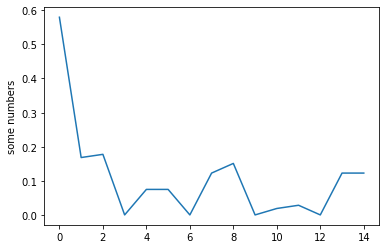

In [7]:
plt.plot(Error)
plt.ylabel('some numbers')
plt.show()

In [9]:
a = Net[Count-1].predict(Test[0])
s =0 
for i in range(len(a)) : 
    if Test[1][i] == a[i] : 
        s +=1 
s /=len(a)
s

0.8208955223880597

In [10]:
PredictionOnTrainSet = []
for i in range(0,Count) : 
    PredictionOnTrainSet.append( Net[i].predict(Test[0]))

In [11]:
FinalPrediction = []
for EachTestCase in range(0, len(Test[1])) : 
    count1 = 0 
    count0 = 0 
    for i in range(0,Count) : 
        if PredictionOnTrainSet[i][EachTestCase] == 1 :
            count1 += 1
        if PredictionOnTrainSet[i][EachTestCase] == 0 :
            count0 += 1
    if count1>count0 : 
        FinalPrediction.append(1)
    else : 
        FinalPrediction.append(0)


In [12]:
acc = 0 
for i in range(len(FinalPrediction)) : 
    if FinalPrediction[i] == Test[1][i] : 
        acc +=1 
acc /= len(FinalPrediction)
acc

0.8134328358208955

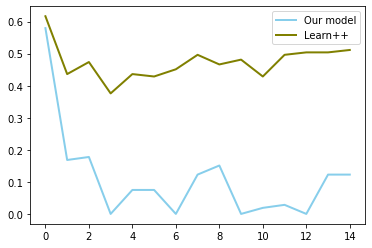

In [44]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Data

df=pd.DataFrame({'Iteration': range(0,len(Error)), 'Our model': Error, 'Learn++':  np.loadtxt('MatlabData.txt',dtype=float) })

# multiple line plot
plt.plot( 'Iteration', 'Our model', data=df, marker='', markerfacecolor='blue', markersize=12, color='skyblue', linewidth=2)
plt.plot( 'Iteration', 'Learn++', data=df, marker='', color='olive', linewidth=2)
plt.legend()
plt.savefig('testplot.png')

In [42]:
import matplotlib.pyplot as plt
import itertools
def plot_cm(cf):
    plt.figure(figsize = (6,6))
    plt.imshow(cf,cmap=plt.cm.Blues,interpolation='nearest')
    plt.colorbar()
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    tick_marks = np.arange(len(set(y_test))) # length of classes
    class_labels = ['0','1']
    tick_marks
    plt.xticks(tick_marks,class_labels)
    plt.yticks(tick_marks,class_labels)
    # plotting text value inside cells
    thresh = cf.max() / 2.
    for i,j in itertools.product(range(cf.shape[0]),range(cf.shape[1])):
        plt.text(j,i,format(cf[i,j],'d'),horizontalalignment='center',color='white' if cf[i,j] >thresh else 'black')
    plt.show();
    plt.savefig('Confusion.png')

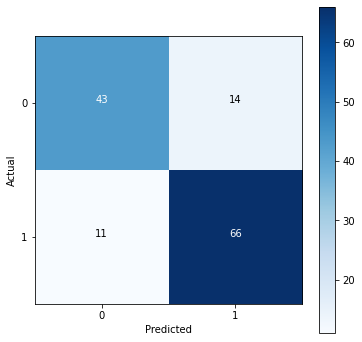

0.7962962962962963


<Figure size 432x288 with 0 Axes>

In [58]:
from sklearn.metrics import confusion_matrix
y_test = Test[1]
pred = FinalPrediction
ourCM = confusion_matrix(y_test, pred)
plot_cm(ourCM)

In [60]:
print((ourCM[0][0] + ourCM[1][1]) / (ourCM[0][0]+ourCM[0][1]+ourCM[1][0]+ourCM[1][1]))
print((ourCM[0][0] ) / (ourCM[0][0]+ourCM[1][0]))


0.8134328358208955
0.7962962962962963


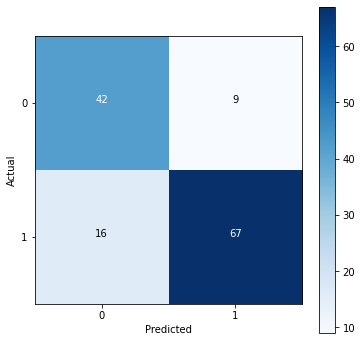

0.8134328358208955
0.7241379310344828


<Figure size 432x288 with 0 Axes>

In [57]:
DataYes = np.loadtxt('FeatureYes.txt',dtype=float)
DataNo = np.loadtxt('FeaturesNo.txt',dtype=float)
DataX = np.array(DataYes.tolist()  + DataNo.tolist() )
DataY = np.array(np.ones(len(DataYes)).tolist() + np.zeros(len(DataNo)).tolist())
DataX , DataY = shuffle(DataX , DataY)
DataX, X_test, DataY, y_test = train_test_split(DataX, DataY, test_size=0.20, random_state=42)

clf = tree.DecisionTreeClassifier()
model = clf.fit(DataX, DataY)
pred = model.predict(X_test)
cm = confusion_matrix(y_test, pred)
plot_cm(cm)
print((cm[0][0] + cm[1][1]) / (cm[0][0]+cm[0][1]+cm[1][0]+cm[1][1])) 
print((cm[0][0] ) / (cm[0][0]+cm[1][0]))

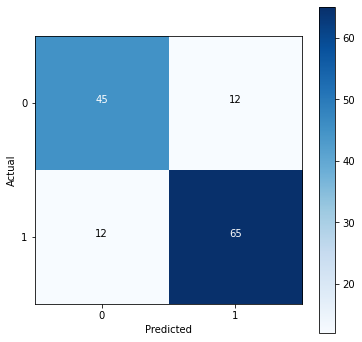

0.8208955223880597
0.7894736842105263


<Figure size 432x288 with 0 Axes>

In [62]:
y_test = Test[1]
pred = PredictionOnTrainSet[Count-1]
ourCM = confusion_matrix(y_test, pred)
plot_cm(ourCM)
print((ourCM[0][0] + ourCM[1][1]) / (ourCM[0][0]+ourCM[0][1]+ourCM[1][0]+ourCM[1][1]))
print((ourCM[0][0] ) / (ourCM[0][0]+ourCM[1][0]))